In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import time

sys.path.append("C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src")

from utils.satellites_data import general_functions as gf
from utils import satellites_data as sd
from utils import generate_radiance_lut_and_uas as glut
from utils import simulate_images as si
from algorithms import matched_filter_variants as mfs

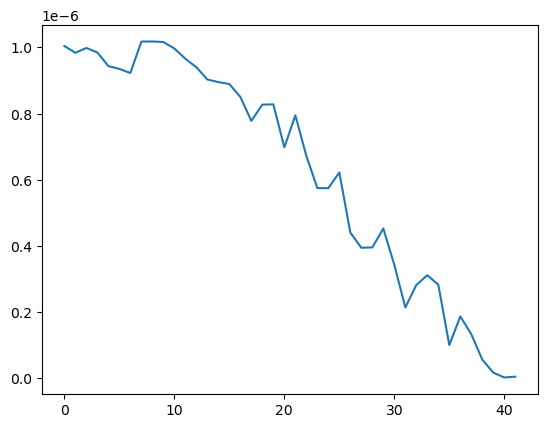

True
background pixels range from 0 to 1013.0546628902055


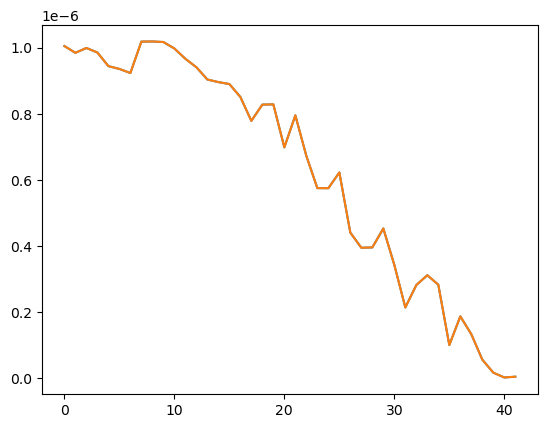

<Figure size 640x480 with 0 Axes>

background pixels range from 0 to 500.0


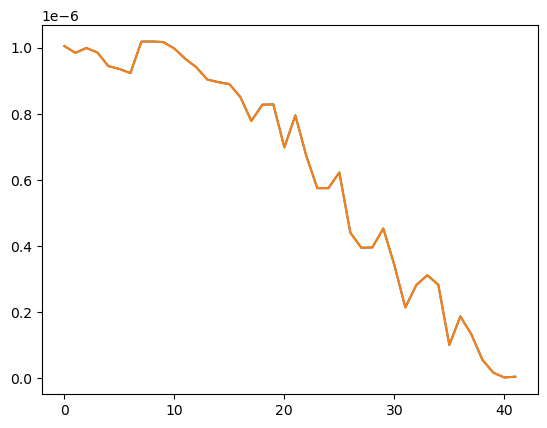

<Figure size 640x480 with 0 Axes>

background pixels range from 0 to 748.077117707787


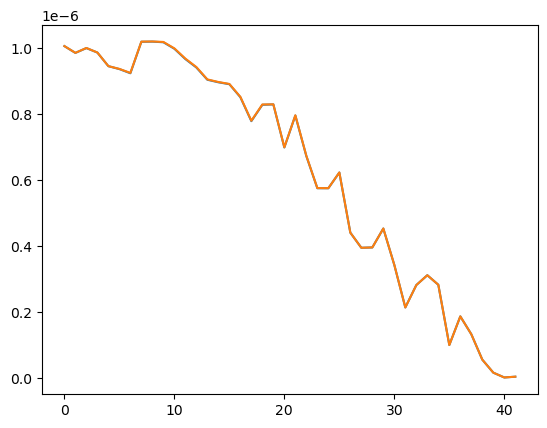

<Figure size 640x480 with 0 Axes>

background pixels range from 0 to 703.7533640711933


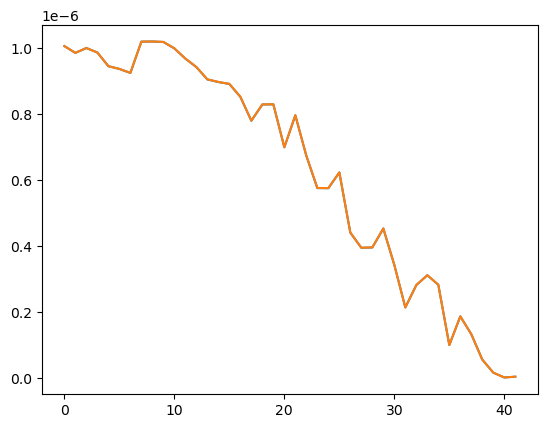

<Figure size 640x480 with 0 Axes>

background pixels range from 0 to 573.1397106459391


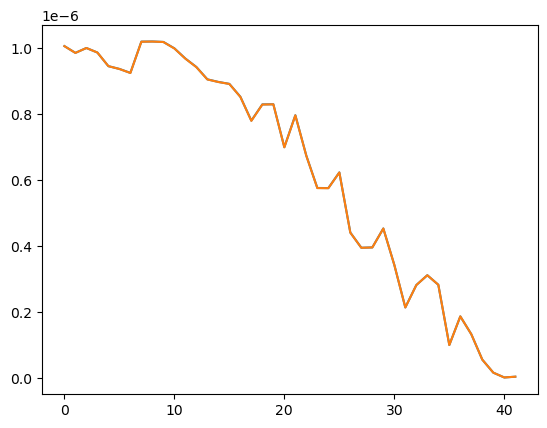

<Figure size 640x480 with 0 Axes>

current_max: 13305.476059839004
current interval 357.48032311137877-4733.063189165834


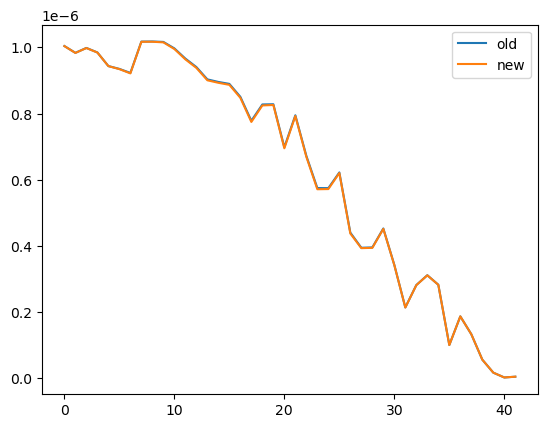

current_max: 2932.248658462892
current interval 357.48032311137877-4733.063189165834


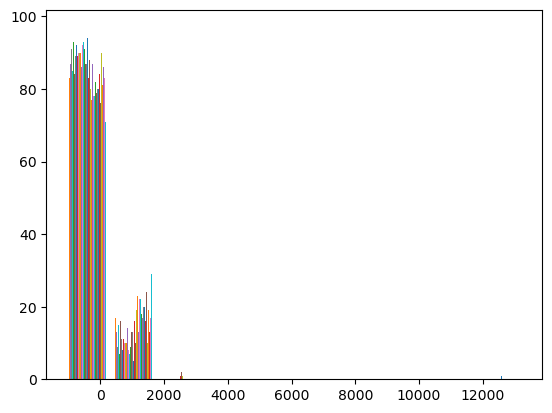

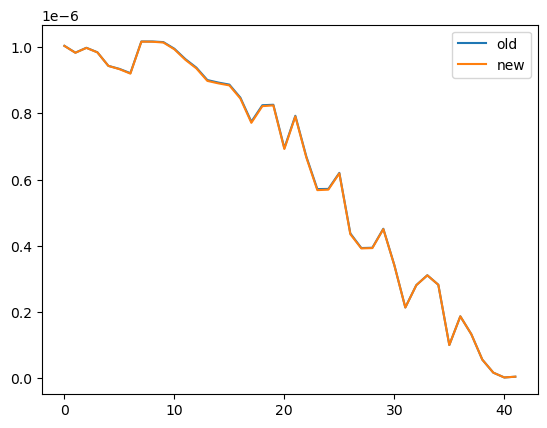

current_max: 2582.5410875700227
current interval 357.48032311137877-4733.063189165834


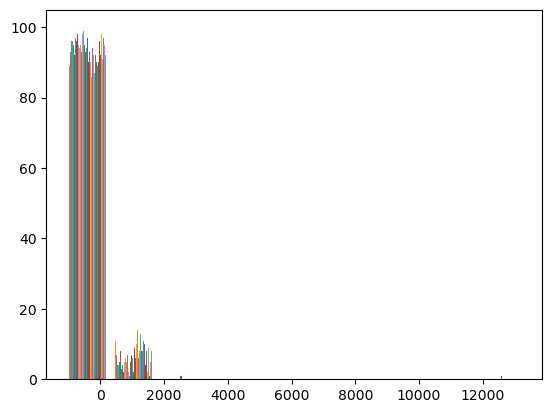

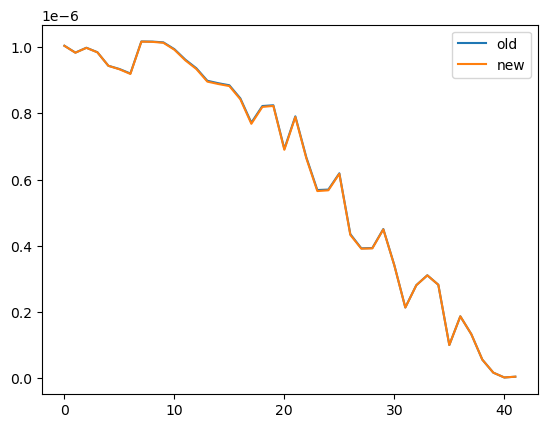

current_max: 2231.6390590030787
current interval 357.48032311137877-4733.063189165834


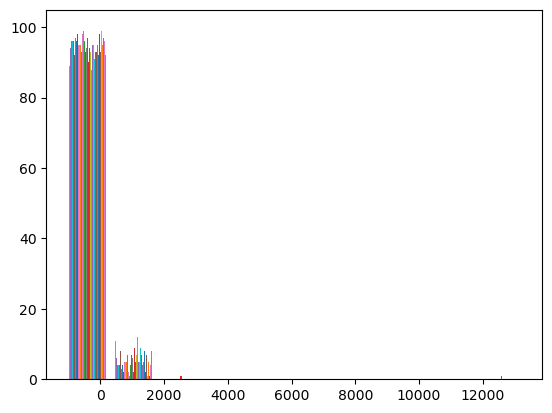

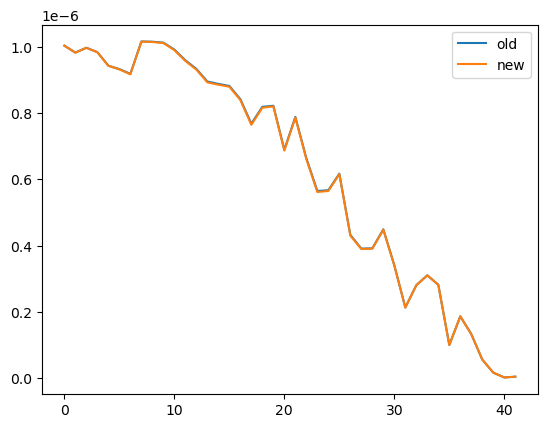

current_max: 1879.5408942438623
current interval 357.48032311137877-4733.063189165834


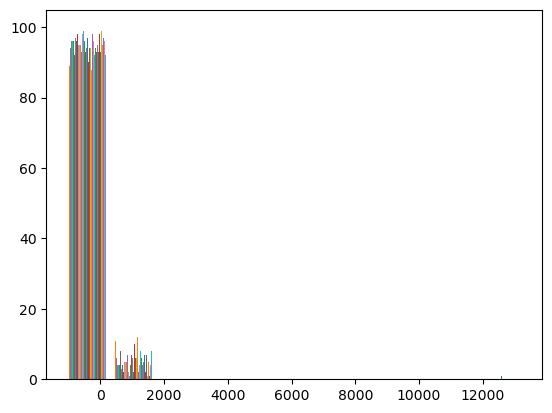

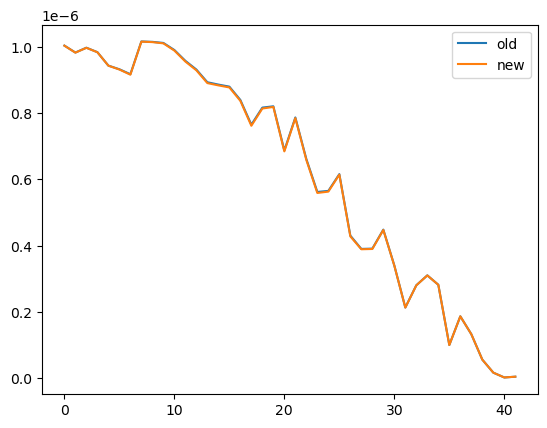

current_max: 1526.2449196017192
current interval 357.48032311137877-4733.063189165834


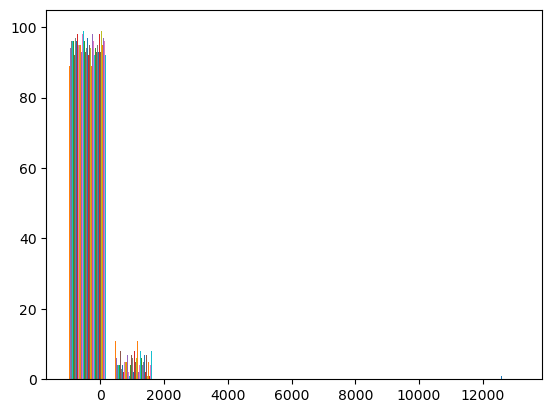

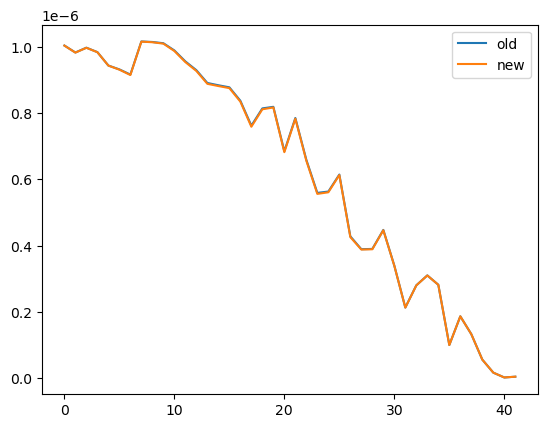

current_max: 1171.7494662254721
current interval 357.48032311137877-4733.063189165834


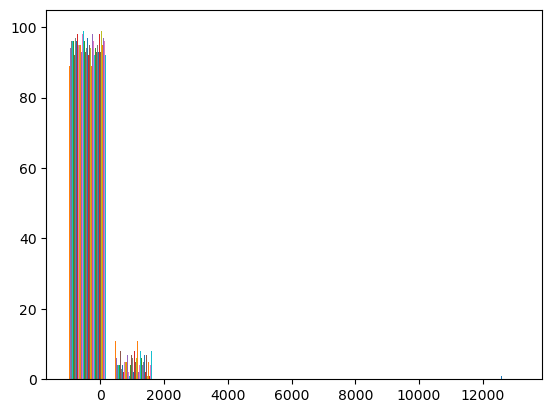

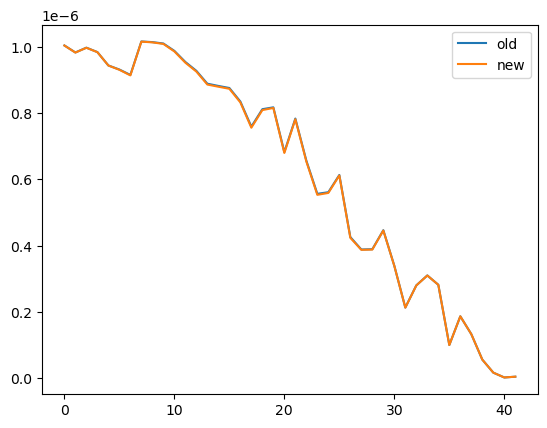

current_max: 816.0528701153194
current interval 357.48032311137877-4733.063189165834


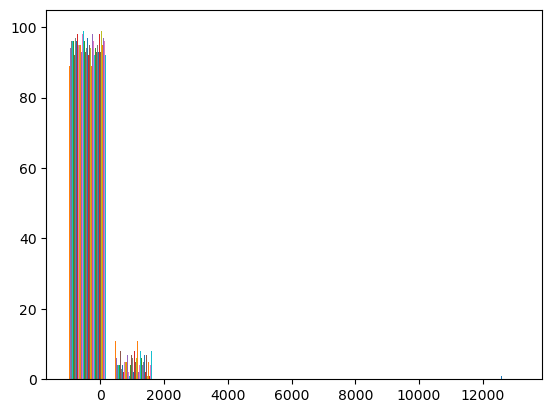

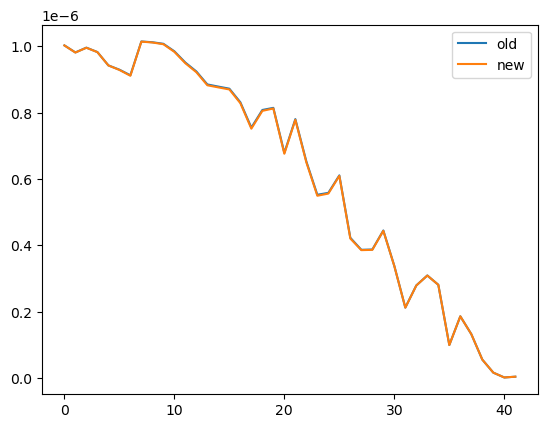

current_max: 459.1534721347212
current interval 357.48032311137877-4733.063189165834


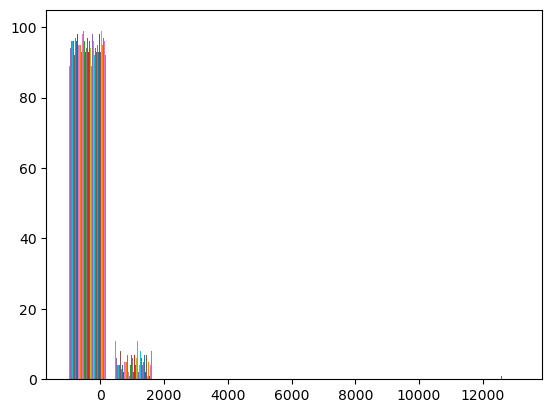

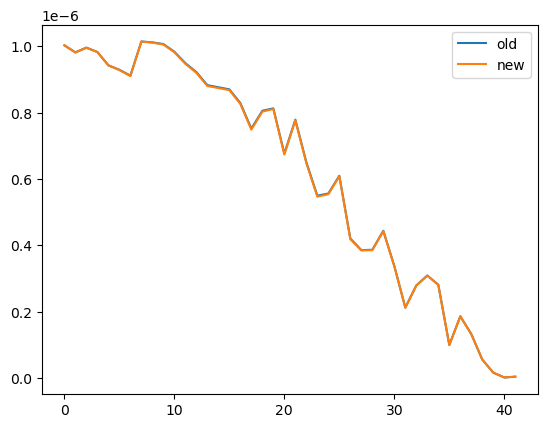

current_max: 101.049618022284
current interval 357.48032311137877-4733.063189165834


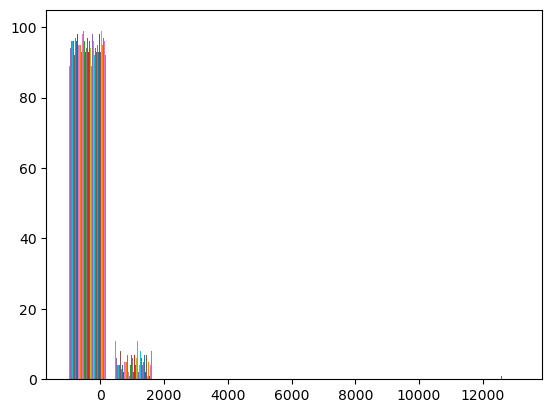

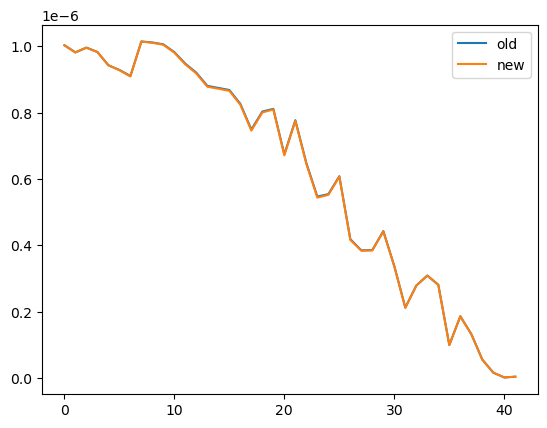

ValueError: zero-size array to reduction operation maximum which has no identity

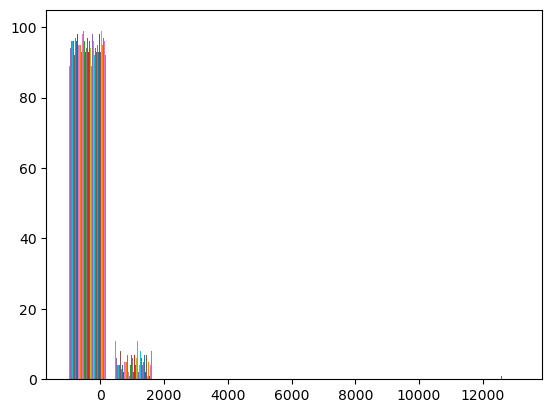

In [80]:

def analyze_distribution(
    concentration: np.ndarray,
    threshold_std: float = 2,
    high_percent: float = 0.035,
) -> bool:
    """
    分析浓度分布是否有甲烷烟羽的迹象，剔除最高的 trim_percent 百分比像素。

    参数:
    - concentration (np.ndarray): 浓度矩阵。
    - threshold_std (float): 计算标准差的倍数阈值，默认为2。
    - trim_percent (float): 剔除的最高百分比像素数，默认为2.5%。

    返回:
    - bool: 如果浓度分布显示可能存在甲烷烟羽则返回 True，否则返回 False。
    """
    mean, std = calculate_modified_mean_std(concentration)

    # 判断是否有烟羽存在
    high_concentration_pixels = np.sum(concentration > mean + threshold_std * std)
    expected_pixels = (
        concentration.size * high_percent
    )  # 在 95% 置信区间之外的期望像素数

    return high_concentration_pixels > expected_pixels


def calculate_modified_mean_std(
    concentration: np.ndarray,
    trim_percent: float = 0.025,
) -> tuple[float, float]:
    """
    计算浓度的均值和标准差，剔除前后 trim_percent 的像素后计算均值，
    并将高浓度部分替换为镜像低浓度值，再计算标准差。

    参数:
    - concentration (np.ndarray): 浓度矩阵。
    - trim_percent (float): 剔除的最高和最低百分比像素数，默认为 2.5%。

    返回:
    - tuple[float, float]: 调整后的均值和标准差。
    """
    # 将浓度值排序，并去除前后 trim_percent 百分比的像素
    sorted_concentration = np.sort(concentration.flatten())
    cutoff_start_index = int(trim_percent * len(sorted_concentration))
    cutoff_end_index = int((1 - trim_percent) * len(sorted_concentration))

    # 提取中间的像素用于初步均值计算
    trimmed_concentration = sorted_concentration[cutoff_start_index:cutoff_end_index]
    mean = np.mean(trimmed_concentration)

    # # 计算剔除后的标准差
    # std = np.std(trimmed_concentration)

    # 添加前 2.5% 的低浓度像素
    adjusted_concentration = sorted_concentration[:cutoff_end_index]

    # 镜像替换高浓度的 2.5% 像素
    mirror_values = 2 * mean - sorted_concentration[:cutoff_start_index][::-1]
    adjusted_concentration[-cutoff_start_index:] = mirror_values

    # 重新计算标准差
    final_std = np.std(adjusted_concentration)

    return mean, final_std


def ml_matched_filter(
    data_cube: np.ndarray,
    initial_unit_absorption_spectrum: np.ndarray,
    modify_result: bool = False,
    albedoadjust: bool = False,
    convergence_threshold=0.05,
) -> np.ndarray:
    """
    基于matched filter方法计算甲烷浓度增强。
    parameters:
    data_cube: np.ndarry 输入的光谱数组
    unit_absorption_spectrum: np.ndarray 单位吸收光谱
    itetate: bool 是否进行迭代
    albedoadjust: bool 是否进行albedo校正

    return: np.ndarray 与影像空间范围对应的甲烷浓度增强结果
    """
    #! Step 0.0: 初始化 参数
    _, rows, cols = data_cube.shape
    concentration = np.zeros((rows, cols))
    albedo = np.ones((rows, cols))

    #! Step 0.1: 计算 背景光谱，目标谱，观测光谱和背景光谱的差值
    background_spectrum = np.nanmean(data_cube, axis=(1, 2))
    target_spectrum = background_spectrum * initial_unit_absorption_spectrum
    radiancediff_with_background = data_cube - background_spectrum[:, None, None]
    plt.figure()
    plt.plot(background_spectrum)
    plt.show()
    #! Step 0.2: 计算协方差矩阵的逆 
    d_covariance = radiancediff_with_background
    covariance = np.tensordot(
        d_covariance,
        d_covariance,
        axes=((1, 2), (1, 2)),
    ) / (rows * cols)
    epsilon = 1e-6
    covariance += epsilon * np.eye(covariance.shape[0])
    covariance_inverse = np.linalg.inv(
        covariance
    )  # 若协方差稳定，用 inv 替代 pinv 加快计算

    #! Step 0.3: 计算反照率校正（如果需要）
    if albedoadjust:
        background_norm = np.dot(background_spectrum, background_spectrum)  # 只计算一次
        albedo = (
            np.einsum("ijk,i->jk", data_cube, background_spectrum) / background_norm
        )
        
    #! Step 0.4: 计算浓度增强结果
    common_denominator = target_spectrum @ covariance_inverse @ target_spectrum
    numerators = np.einsum(
        "ijk,i->jk", radiancediff_with_background, target_spectrum @ covariance_inverse
    )
    concentration = numerators / (albedo * common_denominator)
    
    #! Step 1.1: 进行统计分析
    # 统计浓度结果矩阵的分布统计参数，判断存不存在异常高浓度结果
    previous_mean, previous_std = calculate_modified_mean_std(concentration)
    previous_max = np.max(concentration)
    # 判断是否存在甲烷烟羽
    previous_concentration = concentration.copy()
    max_iterations = 10
    iteration = 0
    has_plume = analyze_distribution(concentration)
    print(has_plume)
    # has_plume = False
    if not has_plume:
        print("No significant plume detected.")
        if modify_result:
            # 基于要求看是否对无烟羽增强对结果进行相对更精准的计算
            while iteration < max_iterations:
                #! Step 1: 更新单位吸收光谱，基于初次计算结果的 3倍标准差范围
                print(f"current uas range from 0 to {previous_max + previous_std}")
                _, unit_absorption_spectrum = (
                    glut.generate_satellite_uas_for_specific_range_from_lut(
                        "AHSI", 0, previous_max + previous_std, 2150, 2500, 25, 0
                    )
                )

                #! Step 2: 更新背景光谱，基于新的单位吸收光谱重新计算, 计算当前的特征谱，以及观测光谱和背景光谱之间的差值
                background_spectrum = np.nanmean(
                    data_cube
                    - (albedo * concentration)[None, :, :]
                    * target_spectrum[:, None, None],
                    axis=(1, 2),
                )
                target_spectrum = background_spectrum * unit_absorption_spectrum
                radiancediff_with_background = (
                    data_cube - background_spectrum[:, None, None]
                )
                
                #! Step 3: 更新协方差矩阵和其逆矩阵
                d_covariance = (
                    radiancediff_with_background
                    - albedo[None, :, :]
                    * concentration[None, :, :]
                    * target_spectrum[:, None, None]
                )

                covariance = np.tensordot(
                    d_covariance,
                    d_covariance,
                    axes=((1, 2), (1, 2)),
                ) / (rows * cols)
                covariance_inverse = np.linalg.pinv(covariance)

                #! Step 4: 使用更新的参数重新计算浓度增强结果
                common_denominator = (
                    target_spectrum @ covariance_inverse @ target_spectrum
                )
                numerators = np.einsum(
                    "ijk,i->jk",
                    radiancediff_with_background,
                    target_spectrum @ covariance_inverse,
                )
                concentration = numerators / (albedo * common_denominator)

                #! Step 5: 判断是否达到收敛条件
                # current_mean,current_std = calculate_modified_mean_std(concentration)
                current_std = np.std(concentration)
                current_mean = np.mean(concentration)
                if (
                    abs(current_std - previous_std) / previous_std
                    < convergence_threshold
                ):
                    print(
                        f"Iteration {iteration + 1}: Converged with std change {abs(current_std - previous_std)}."
                    )
                    break

                # 更新前一次的标准差并递增迭代次数
                previous_std = current_std
                previous_mean = current_mean
                iteration += 1

    else:
        
        #! Step 1.2:将浓度分成两部分，低于阈值的为背景像素，高于阈值的为潜在烟羽像素，但此时使用一倍标准差作为阈值
        plume_mask = previous_concentration > previous_mean + 2*previous_std
        non_plume_mask = previous_concentration <= previous_mean + 2*previous_std
        
        #! Step 2.0: 对于背景像素部分，按无烟羽情况进行更新
        if np.any(non_plume_mask):
            iteration = 0
            max_iterations = 5
            while iteration < max_iterations:
                #! Step 2.1: 基于该部分浓度范围，更新背景像素的单位吸收光谱
                upper = np.maximum(500, previous_mean + 3*previous_std)
                print(f"background pixels range from 0 to {upper}")
                _, unit_absorption_spectrum = (
                    glut.generate_satellite_uas_for_specific_range_from_lut(
                        "AHSI", 0, upper, 2150, 2500, 25, 0
                    )
                )
                #! Step 2.2: 更新背景光谱,目标谱以及 观测光谱和背景谱之间的差值
                # 去除前一步 甲烷浓度增强带来的影响
                plt.figure()
                plt.plot(background_spectrum,label="old")
                background_spectrum = np.nanmean(
                    data_cube[:, non_plume_mask]
                    - (
                        albedo[non_plume_mask]
                        * previous_concentration[non_plume_mask]
                        * target_spectrum[:, None]
                    ),
                    axis=1,
                )
                plt.plot(background_spectrum,label="new")
                plt.figure()
                plt.show()
                
                # 计算背景像素的特征光谱
                target_spectrum = background_spectrum * unit_absorption_spectrum
                
                # 计算观测光谱 和 背景光谱之间的差值
                radiancediff_with_background[:,non_plume_mask] = (
                    data_cube[:, non_plume_mask] - background_spectrum[:, None]
                )

                #! Step 2.3: 更新协方差矩阵
                # 计算观测光谱和理论光谱之间的差值
                d_covariance[:,non_plume_mask] = data_cube[:, non_plume_mask] - (
                    background_spectrum[:,None]
                    + albedo[non_plume_mask]
                    * previous_concentration[non_plume_mask]
                    * target_spectrum[:, None]
                )
                # 更新协方差矩阵和其逆
                covariance = np.tensordot(
                    d_covariance[:,non_plume_mask], d_covariance[:,non_plume_mask], axes=((1), (1))
                ) / np.sum(non_plume_mask)
                epsilon = 1e-6
                covariance += epsilon * np.eye(covariance.shape[0])
                covariance_inverse = np.linalg.inv(covariance)

                #! Step 2.4: 重新计算浓度增强
                common_denominator = (
                    target_spectrum @ covariance_inverse @ target_spectrum
                )

                # 使用更新后的参数重新计算背景像素部分的浓度
                numerators = np.einsum(
                    "ij,i->j",
                    radiancediff_with_background[:,non_plume_mask],
                    target_spectrum @ covariance_inverse,
                )
                concentration[non_plume_mask] = numerators / (
                    albedo[non_plume_mask] * common_denominator
                )
                
                #! Step 2.5: 判断是否达到收敛条件
                current_mean = np.mean(concentration[non_plume_mask])
                current_std = np.std(concentration[non_plume_mask])
                if (
                    abs(current_std - previous_std) / previous_std < convergence_threshold
                ):
                    print(
                        f"Iteration {iteration}: Converged with std change {abs(current_std - previous_std)}."
                    )
                    break

                # 更新前一次的标准差并递增迭代次数
                previous_concentration = concentration
                non_plume_mask = concentration <= current_mean + current_std
                previous_std = current_std
                previous_mean = current_mean
                iteration += 1
        
        #! Step 3.0: 对于可能的甲烷排放像素，基于前一步进行浓度值更新
        iteration = 0
        max_iterations = 10
        max_value = np.minimum(50000, previous_max)
        if max_value - (previous_mean + 2*previous_std) <= 5000:
            num_concentration_intervals = 1
        elif 2000 < max_value - (previous_mean + 2*previous_std) <= 10000:
            num_concentration_intervals = 2
        elif 10000 < max_value - (previous_mean + 2*previous_std) <= 20000:
            num_concentration_intervals = 3
        elif 20000 < max_value - (previous_mean + 2*previous_std) <= 50000:
            num_concentration_intervals = 4
        
        concentration_intervals = np.linspace(
                    previous_mean + 2*previous_std,
                    max_value + previous_std,
                    num_concentration_intervals + 1,
                )
        for idx in range(num_concentration_intervals):
            iteration = 0
            max_iterations = 10
            background_spectrum_local = background_spectrum.copy()
            while iteration < max_iterations:
                #! Step 3.1: 对于烟羽像素部分，按照浓度范围划分区间 更新浓度
                if np.any(plume_mask):
                    print(f"current_max: {max_value}")
                    conc_min = concentration_intervals[idx]
                    conc_max = concentration_intervals[idx+1]
                    print(f"current interval {conc_min}-{conc_max}")
                    # 创建当前区间的掩膜
                    interval_mask = (previous_concentration > conc_min) & (
                        previous_concentration <= conc_max
                    )
                    #! Step 3.2: 更新背景光谱，计算特征谱和 观测光谱与背景光谱的差值
                    _, unit_absorption_spectrum_local = (
                        glut.generate_satellite_uas_for_specific_range_from_lut(
                            "AHSI",
                            conc_min,
                            conc_max,
                            # conc_min,
                            # conc_max,
                            2150,
                            2500,
                            25,
                            0,
                        )
                    )
                    plt.figure()    
                    plt.plot(background_spectrum,label="old")
                    background_spectrum_local = background_spectrum + conc_min*target_spectrum
                    plt.plot(background_spectrum,label='new')
                    plt.legend()
                    plt.show()
                    
                    # 计算背景像素的特征光谱
                    target_spectrum = background_spectrum * unit_absorption_spectrum_local
                    # 计算观测光谱 和 背景光谱之间的差值
                    radiancediff_with_background[:,interval_mask] = (
                        data_cube[:, interval_mask] - background_spectrum[:, None]
                    )

                    #! Step 3.3: 更新协方差矩阵
                    # 计算观测光谱和理论光谱之间的差值
                    # d_covariance[:,interval_mask] = data_cube[:, interval_mask] - (
                    #     background_spectrum[:,None]
                    #     + albedo[non_plume_mask]
                    #     * previous_concentration[non_plume_mask]
                    #     * target_spectrum[:, None]
                    # )
                    # # 更新协方差矩阵和其逆
                    # covariance = np.tensordot(
                    #     d_covariance[:,non_plume_mask], d_covariance[:,non_plume_mask], axes=((1), (1))
                    # ) / np.sum(non_plume_mask)
                    # epsilon = 1e-6
                    # covariance += epsilon * np.eye(covariance.shape[0])
                    # covariance_inverse = np.linalg.inv(covariance)

                    #! Step 3.4: 重新计算浓度增强
                    common_denominator = (
                        target_spectrum @ covariance_inverse @ target_spectrum
                    )

                    # 使用更新后的参数重新计算背景像素部分的浓度
                    numerators = np.einsum(
                        "ij,i->j",
                        radiancediff_with_background[:,interval_mask],
                        target_spectrum @ covariance_inverse,
                    )
                    concentration[interval_mask] = numerators / (
                        albedo[interval_mask] * common_denominator
                    ) + conc_min
                    
                    plt.figure()
                    plt.hist(concentration)
                    #! Step 3.5: 判断是否达到收敛条件
                    current_max = np.minimum(50000, np.max(concentration[interval_mask]))
                    if (
                        abs(current_max - conc_max) / conc_max < convergence_threshold
                    ):
                        print(
                            f"Iteration {iteration}: Converged with std change {abs(current_std - previous_std)}."
                        )
                        break

                    # 更新前一次的标准差并递增迭代次数
                    previous_concentration = concentration
                    previous_std = current_std
                    previous_mean = current_mean
                    max_value = current_max
                    iteration += 1
                #         radiancediff_with_background[maskList[idx]] = data_cube[:,maskList[idx]] - current_bg[:,None]
                        
                #         #? 是否要更新 albedo 校正项
                        

                #         #! Step 3.5: 更新协方差矩阵
                        
                #         current_mask = previous_concentration <=conc_max

                #         # 更新协方差矩阵和其逆
                #         covariance_local = (
                #             d_covariance_local[current_mask] @ d_covariance_local[current_mask].T
                #         ) / np.sum(current_mask)
                #         covariance_inverse_local = np.linalg.pinv(covariance_local)

                #         # 计算更新后的general分母项
                #         common_denominator_masked = (
                #             target_spectrum_local
                #             @ covariance_inverse_local
                #             @ target_spectrum_local
                #         )

                #         # Step 6.5: 重新计算当前区间的浓度
                #         numerators_local = (
                #             target_spectrum_local
                #             @ covariance_inverse
                #             @ radiancediff_with_background[maskList[idx]]
                #         )
                #         concentration_flat = concentration.flatten()
                #         albedo_flat = albedo.flatten()

                #         # 更新浓度
                #         concentration_flat[maskList[idx].flatten()] = (
                #             numerators_local
                #             / (albedo_flat[maskList[idx].flatten()] * common_denominator_masked)
                #             + conc_min
                #         )
                #         concentration = concentration_flat.reshape(rows, cols)
                #! Step 3.1 依靠浓度范围进行区间间隔划分
                # if max_value - (previous_mean + previous_std) <= 5000:
                #     num_concentration_intervals = 1
                # elif 2000 < max_value - (previous_mean + previous_std) <= 10000:
                #     num_concentration_intervals = 2
                # elif 10000 < max_value - (previous_mean + previous_std) <= 20000:
                #     num_concentration_intervals = 3
                # elif 20000 < max_value - (previous_mean + previous_std) <= 50000:
                #     num_concentration_intervals = 5
                # num_concentration_intervals = 1

                # concentration_intervals = np.linspace(
                #     previous_mean + previous_std,
                #     max_value,
                #     num_concentration_intervals + 1,
                # )

                # # 复制全局背景光谱
                # background_spectrum_local = background_spectrum.copy()
                # target_spectrum_local = target_spectrum.copy()
                # d_covariance_local = d_covariance
                # #! Step 3.2: 循环处理每个浓度区间
                # maskList = []
                # interval_uas_list = []
                # for idx in range(num_concentration_intervals):
                #     conc_min = concentration_intervals[idx]
                #     conc_max = concentration_intervals[idx + 1]
                #     print(f"current interval {conc_min}-{conc_max}")
                #     # 创建当前区间的掩膜
                #     interval_mask = (previous_concentration > conc_min) & (
                #         previous_concentration <= conc_max
                #     )
                #     maskList.append(interval_mask)
                #     interval_low =np.maximum(0,conc_min - 0.25 * (conc_max - conc_min)) 
                #     interval_high = np.minimum(50000,conc_max + 0.25 * (conc_max - conc_min))
                #     _, unit_absorption_spectrum_local = (
                #         glut.generate_satellite_uas_for_specific_range_from_lut(
                #             "AHSI",
                #             conc_min,
                #             conc_max + 0.25 * (conc_max - conc_min),
                #             # conc_min,
                #             # conc_max,
                #             2150,
                #             2500,
                #             25,
                #             0,
                #         )
                #     )
                #     interval_uas_list.append(unit_absorption_spectrum_local)
                # for idx in range(num_concentration_intervals):
                #     conc_min = concentration_intervals[idx]
                #     conc_max = concentration_intervals[idx + 1]
                #     if np.any(maskList[0]):
                #         #! Step 3.3: 生成对应的单位吸收光谱
                #         #! Step 3.4: 更新背景光谱， 使用前一个的背景光谱 叠加阈值浓度甲烷影像带来radiance衰减，
                #         d_covariance_local[:,non_plume_mask] = data_cube[:,non_plume_mask] - (background_spectrum + albedo[non_plume_mask](num_concentration_intervals[0] - previous_concentration[non_plume_mask])*target_spectrum)[:,None]
                #         for i in range(idx+1):
                #             current_uas = interval_uas_list[i]
                #             current_bg = background_spectrum_local + num_concentration_intervals[i]*target_spectrum_local
                #             target_spectrum_local = current_bg*current_uas
                #             d_covariance_local[:,maskList[i]] = data_cube[:,maskList[i]] - (current_bg + albedo[maskList[i]](previous_concentration[maskList[i]]-num_concentration_intervals[i+1])*target_spectrum_local)
                            
                #         radiancediff_with_background[maskList[idx]] = data_cube[:,maskList[idx]] - current_bg[:,None]
                        
                #         #? 是否要更新 albedo 校正项
                        

                #         #! Step 3.5: 更新协方差矩阵
                        
                #         current_mask = previous_concentration <=conc_max

                #         # 更新协方差矩阵和其逆
                #         covariance_local = (
                #             d_covariance_local[current_mask] @ d_covariance_local[current_mask].T
                #         ) / np.sum(current_mask)
                #         covariance_inverse_local = np.linalg.pinv(covariance_local)

                #         # 计算更新后的general分母项
                #         common_denominator_masked = (
                #             target_spectrum_local
                #             @ covariance_inverse_local
                #             @ target_spectrum_local
                #         )

                #         # Step 6.5: 重新计算当前区间的浓度
                #         numerators_local = (
                #             target_spectrum_local
                #             @ covariance_inverse
                #             @ radiancediff_with_background[maskList[idx]]
                #         )
                #         concentration_flat = concentration.flatten()
                #         albedo_flat = albedo.flatten()

                #         # 更新浓度
                #         concentration_flat[maskList[idx].flatten()] = (
                #             numerators_local
                #             / (albedo_flat[maskList[idx].flatten()] * common_denominator_masked)
                #             + conc_min
                #         )
                #         concentration = concentration_flat.reshape(rows, cols)
            # Step 6: 判断是否达到收敛条件

            

    return concentration


def ml_matched_filter_new(
    data_cube: np.ndarray,
    initial_unit_absorption_spectrum: np.ndarray,
    modify_result: bool = False,
    albedoadjust: bool = False,
    convergence_threshold=0.05,
    max_iterations=10,
) -> np.ndarray:
    """
    基于多层匹配滤波方法计算甲烷浓度增强。

    参数：
    - data_cube: np.ndarray,输入的光谱数据立方体，形状为 (bands, rows, cols)
    - initial_unit_absorption_spectrum: np.ndarray,初始单位吸收光谱，形状为 (bands,)
    - modify_result: bool,是否在无明显烟羽时进行结果精化
    - albedoadjust: bool,是否进行反照率校正
    - convergence_threshold: float,收敛判断的阈值
    - max_iterations: int,最大迭代次数

    返回：
    - concentration: np.ndarray,浓度增强结果,形状为 (rows, cols)
    """
    # 初始化参数
    bands, rows, cols = data_cube.shape
    concentration = np.zeros((rows, cols))
    albedo = np.ones((rows, cols))

    # 初始化背景光谱和目标光谱
    background_spectrum = np.nanmean(data_cube, axis=(1, 2))
    target_spectrum = background_spectrum * initial_unit_absorption_spectrum

    # 计算初始的辐射差异和协方差矩阵
    radiancediff_with_background = data_cube - background_spectrum[:, None, None]
    d_covariance = radiancediff_with_background.copy()

    covariance = np.tensordot(
        d_covariance,
        d_covariance,
        axes=((1, 2), (1, 2)),
    ) / ((rows * cols) - 1)
    epsilon = 1e-6
    covariance += epsilon * np.eye(covariance.shape[0])
    covariance_inverse = np.linalg.inv(covariance)

    # 计算初始的浓度增强结果
    common_denominator = target_spectrum @ covariance_inverse @ target_spectrum

    if albedoadjust:
        background_norm = np.dot(background_spectrum, background_spectrum)
        albedo = (
            np.einsum("ijk,i->jk", data_cube, background_spectrum) / background_norm
        )

    numerators = np.einsum(
        "ijk,i->jk",
        radiancediff_with_background,
        covariance_inverse @ target_spectrum,
    )
    concentration = numerators / (albedo * common_denominator)

    # 开始迭代过程
    previous_concentration = concentration.copy()
    iteration = 0

    while iteration < max_iterations:
        # 计算浓度的统计参数
        previous_mean, previous_std = calculate_modified_mean_std(concentration)
        previous_max = np.max(concentration)
        previous_min = np.min(concentration)
        # 判断是否存在甲烷烟羽
        has_plume = analyze_distribution(concentration)
        print(f"Iteration {iteration + 1}, Has plume: {has_plume}")

        if not has_plume:
            print("No significant plume detected.")
            if not modify_result:
                break  # 不进行进一步的精化计算
            else:
                # 更新单位吸收光谱，基于当前浓度估计
                _, unit_absorption_spectrum = (
                    glut.generate_satellite_uas_for_specific_range_from_lut(
                        "AHSI", 0, previous_mean + previous_max, 2150, 2500, 25, 0
                    )
                )
                # 更新背景光谱
                delta_L = (
                    albedo * concentration
                ) * target_spectrum[:, None, None]
                background_spectrum = np.nanmean(
                    data_cube - delta_L, axis=(1, 2)
                )
                target_spectrum = background_spectrum * unit_absorption_spectrum

                # 更新辐射差异和协方差矩阵
                radiancediff_with_background = data_cube - background_spectrum[:, None, None]
                d_covariance = (
                    radiancediff_with_background - delta_L
                )
                covariance = np.tensordot(
                    d_covariance,
                    d_covariance,
                    axes=((1, 2), (1, 2)),
                ) / ((rows * cols) - 1)
                covariance += epsilon * np.eye(covariance.shape[0])
                covariance_inverse = np.linalg.inv(covariance)

                # 更新浓度增强结果
                common_denominator = target_spectrum @ covariance_inverse @ target_spectrum

                numerators = np.einsum(
                    "ijk,i->jk",
                    radiancediff_with_background,
                    covariance_inverse @ target_spectrum,
                )
                concentration = numerators / (albedo * common_denominator)
        else:
            # 存在甲烷烟羽，进行多层级处理
            # 将浓度划分为多个层级
            # 初始背景光谱
            num_concentration_intervals = 3  # 您可以根据需要调整层级数量
            concentration_levels = np.linspace(
                previous_mean, previous_max, num_concentration_intervals + 1
            )
            
            background_spectrum_layer = background_spectrum.copy()
            target_spectrum_layer = target_spectrum.copy()
            for idx in range(num_concentration_intervals):
                conc_min = concentration_levels[idx]
                conc_max = concentration_levels[idx + 1]
                print(f"Processing concentration interval: {conc_min} - {conc_max}")

                # 创建当前层级的掩膜
                layer_mask = (concentration > conc_min) & (concentration <= conc_max)

                if np.any(layer_mask):
                    # 更新单位吸收光谱
                    _, unit_absorption_spectrum_layer = (
                        glut.generate_satellite_uas_for_specific_range_from_lut(
                            "AHSI",
                            conc_min,
                            conc_max,
                            2150,
                            2500,
                            25,
                            0,
                        )
                    )

                    # 更新背景光谱，基于前一个层级的背景光谱
                    
                    delta_L = (
                        albedo[layer_mask] * concentration[layer_mask]
                    ) * target_spectrum_layer[:, None]
                    L_bg_estimates = data_cube[:, layer_mask] + delta_L
                    
                    background_spectrum_layer = np.nanmean(L_bg_estimates, axis=1)
                    plt.figure()
                    plt.plot(background_spectrum,label = "old")
                    plt.plot(background_spectrum_layer,label = "new")
                    plt.legend()
                    plt.show()
                    target_spectrum_layer = (
                        background_spectrum_layer * unit_absorption_spectrum_layer
                    )

                    # 计算辐射差异和协方差矩阵
                    radiancediff_with_background_layer = (
                        data_cube[:, layer_mask] - background_spectrum_layer[:, None]
                    )
                    
                    # delta_L = (
                    #     albedo[layer_mask] * concentration[layer_mask]
                    # ) * target_spectrum_layer[:, None]
                    
                    d_covariance_layer = (
                        radiancediff_with_background_layer
                        - delta_L
                    )

                    covariance_layer = np.cov(d_covariance_layer)
                    covariance_layer += epsilon * np.eye(covariance_layer.shape[0])
                    covariance_inverse_layer = np.linalg.inv(covariance_layer)

                    # 更新浓度增强结果
                    common_denominator_layer = (
                        target_spectrum_layer @ covariance_inverse_layer @ target_spectrum_layer
                    )

                    numerators_layer = np.einsum(
                        "ij,i->j",
                        radiancediff_with_background_layer,
                        covariance_inverse_layer @ target_spectrum_layer,
                    )
                    concentration[layer_mask] = numerators_layer / (
                        albedo[layer_mask] * common_denominator_layer
                    )
                    # 更新背景光谱供下一层级使用
                    background_spectrum = background_spectrum_layer.copy()
                    target_spectrum = target_spectrum_layer.copy()
                else:
                    print(f"No pixels in concentration interval: {conc_min} - {conc_max}")

        # 判断是否达到收敛条件
        concentration_change = np.abs(concentration - previous_concentration)
        max_change = np.max(concentration_change)
        print(f"Iteration {iteration + 1}, Max concentration change: {max_change}")

        if max_change < convergence_threshold:
            print(f"Converged after {iteration + 1} iterations.")
            break

        previous_concentration = concentration.copy()
        iteration += 1

    return concentration


def ml_matched_filter_simulation_test():
    plume = np.load(
        r"C:\Users\RS\VSCode\matchedfiltermethod\src\data\simulated_plumes\gaussianplume_1000_2_stability_D.npy"
    )
    simulated_radiance_cube = si.simulate_satellite_images_with_plume(
        "AHSI", plume, 25, 0, 2150, 2500, 0.01
    )
    # unit_absoprtion_spectrum_path = "C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src\\data\\uas_files\\AHSI_unit_absorption_spectrum.txt"
    # _, unit_absoprtion_spectrum = gf.open_unit_absorption_spectrum(
    #     unit_absoprtion_spectrum_path, 2150, 2500
    # )
    _, unit_absorption_spectrum = (
        glut.generate_satellite_uas_for_specific_range_from_lut(
            "AHSI", 0, 36000, 2150, 2500, 25, 0
        )
    )
    startime = time.time()
    methane_concentration = ml_matched_filter(
        simulated_radiance_cube, unit_absorption_spectrum
    )
    print(methane_concentration.shape)
    finish_time = time.time()
    print(f"running time: {finish_time - startime}")

    # 计算统计信息
    mean_concentration = np.mean(methane_concentration)
    std_concentration = np.std(methane_concentration)
    max_concentration = np.max(methane_concentration)
    min_concentration = np.min(methane_concentration)
    print(f"Mean: {mean_concentration:.2f} ppm")
    print(f"Std: {std_concentration:.2f} ppm")
    print(f"Max: {max_concentration:.2f} ppm")
    print(f"Min: {min_concentration:.2f} ppm")

    # 创建图形和子图
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # 子图1：甲烷浓度二维数组的可视化
    im = axes[0].imshow(methane_concentration, cmap="viridis", origin="lower")
    axes[0].set_title("Methane Concentration Enhancement (2D)")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")

    # 将 colorbar 移到下方
    cbar = fig.colorbar(
        im, ax=axes[0], orientation="horizontal", shrink=0.7, fraction=0.046, pad=0.04
    )
    cbar.set_label("Methane Concentration (ppm)")

    # 在第一个子图上添加统计信息
    stats_text = (
        f"Mean: {mean_concentration:.2f} ppm\n"
        f"Std: {std_concentration:.2f} ppm\n"
        f"Max: {max_concentration:.2f} ppm\n"
        f"Min: {min_concentration:.2f} ppm"
    )
    axes[0].text(
        1.05,
        0.5,
        stats_text,
        transform=axes[0].transAxes,
        fontsize=12,
        va="center",
        bbox=dict(facecolor="white", alpha=0.6),
    )

    # 子图2：甲烷浓度分布的直方图和 KDE 图
    sns.histplot(methane_concentration.flatten(), bins=50, kde=True, ax=axes[1])
    axes[1].set_title("Distribution of Methane Concentration")
    axes[1].set_xlabel("Methane Concentration (ppm)")
    axes[1].set_ylabel("Frequency")

    # 调整布局
    fig.tight_layout()
    # 显示图表
    plt.show()

    return


def ml_matched_filter_real_image_test():
    filepath = "C:\\Users\\RS\\Desktop\\GF5-02_李飞论文所用数据\\GF5B_AHSI_W102.8_N32.3_20220424_003345_L10000118222\\GF5B_AHSI_W102.8_N32.3_20220424_003345_L10000118222_SW.tif"
    outputfolder = "C:\\Users\\RS\\Desktop\\GF5-02_李飞论文所用数据\\mf_result\\"
    filename = os.path.basename(filepath)
    outputfile = os.path.join(outputfolder, filename)
    if os.path.exists(outputfile):
        return

    _, image_cube = sd.AHSI_data.get_calibrated_radiance(filepath, 2150, 2500)
    image_sample_cube = image_cube[:, 500:600, 700:800]
    unit_absoprtion_spectrum_path = "C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src\\data\\uas_files\\AHSI_unit_absorption_spectrum.txt"

    # _, unit_absoprtion_spectrum = gf.open_unit_absorption_spectrum(
    #     unit_absoprtion_spectrum_path, 2150, 2500
    # )
    _, unit_absorption_spectrum = (
        glut.generate_satellite_uas_for_specific_range_from_lut(
            "AHSI", 0, 40000, 2150, 2500, 25, 0
        )
    )
    startime = time.time()
    # methane_concentration = mfs.ml_matched_filter(
    #     data_cube=image_sample_cube,
    #     unit_absorption_spectrum_array=unit_absoprtion_spectrum,
    #     albedoadjust=False,
    # )
    methane_concentration = ml_matched_filter(
        image_sample_cube, unit_absorption_spectrum
    )
    print(methane_concentration.shape)
    finish_time = time.time()
    print(f"running time: {finish_time - startime}")

    # # sd.AHSI_data.export_ahsi_array_to_tiff(
    # #     methane_concentration,
    # #     filepath,
    # #     outputfolder,
    # # )

    # 计算统计信息
    mean_concentration = np.mean(methane_concentration)
    std_concentration = np.std(methane_concentration)
    max_concentration = np.max(methane_concentration)
    min_concentration = np.min(methane_concentration)
    print(f"Mean: {mean_concentration:.2f} ppm")
    print(f"Std: {std_concentration:.2f} ppm")
    print(f"Max: {max_concentration:.2f} ppm")
    print(f"Min: {min_concentration:.2f} ppm")

    # 创建图形和子图
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # 子图1：甲烷浓度二维数组的可视化
    im = axes[0].imshow(methane_concentration, cmap="viridis", origin="lower")
    axes[0].set_title("Methane Concentration Enhancement (2D)")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")

    # 将 colorbar 移到下方
    cbar = fig.colorbar(
        im, ax=axes[0], orientation="horizontal", shrink=0.7, fraction=0.046, pad=0.04
    )
    cbar.set_label("Methane Concentration (ppm)")

    # 在第一个子图上添加统计信息
    stats_text = (
        f"Mean: {mean_concentration:.2f} ppm\n"
        f"Std: {std_concentration:.2f} ppm\n"
        f"Max: {max_concentration:.2f} ppm\n"
        f"Min: {min_concentration:.2f} ppm"
    )
    axes[0].text(
        1.05,
        0.5,
        stats_text,
        transform=axes[0].transAxes,
        fontsize=12,
        va="center",
        bbox=dict(facecolor="white", alpha=0.6),
    )

    # 子图2：甲烷浓度分布的直方图和 KDE 图
    sns.histplot(methane_concentration.flatten(), bins=50, kde=True, ax=axes[1])
    axes[1].set_title("Distribution of Methane Concentration")
    axes[1].set_xlabel("Methane Concentration (ppm)")
    axes[1].set_ylabel("Frequency")

    # 调整布局
    fig.tight_layout()

    # 显示图表
    plt.show()

    return


def polyfit_plot(enhancements, resultlist, ax, labelstr):
    slope, intercept = np.polyfit(enhancements, resultlist, 1)
    x_fit = np.linspace(min(enhancements), max(enhancements), 100)
    y_fit = slope * x_fit + intercept
    if intercept > 0:
        ax.plot(
            x_fit, y_fit, label=f"{labelstr}:y = {slope:.2f}x + {np.abs(intercept):.2f}"
        )
    elif intercept < 0:
        ax.plot(
            x_fit, y_fit, label=f"{labelstr}:y = {slope:.2f}x - {np.abs(intercept):.2f}"
        )
    else:
        ax.plot(x_fit, y_fit, label=f"{labelstr}:y = {slope:.2f}x")


def image_level_test3_3():
    """
    对叠加了高斯扩散模型的甲烷烟羽模拟影像进行浓度反演
    """
    # 读取烟羽 以及 叠加了烟羽的模拟影像
    plume_path = "C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src\\data\\simulated_plumes\\gaussianplume_1000_8_stability_D.npy"
    plume = np.load(plume_path)
    simulated_image = si.simulate_satellite_images_with_plume(
        "AHSI", plume, 25, 0, 2150, 2500, 0.01
    )
    _, general_uas = glut.generate_satellite_uas_for_specific_range_from_lut(
        "AHSI", 0, 50000, 2150, 2500, 25, 0
    )

    # 读取单位吸收光谱列表
    uaslist = []
    _, uas = glut.generate_satellite_uas_for_specific_range_from_lut(
        "AHSI", 0, 50000, 2150, 2500, 25, 0
    )
    uaslist.append(uas)

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    ax1, ax2, ax3, ax4 = axes.flatten()

    enhancement = mfs.matched_filter(simulated_image, general_uas, True, True)
    plume_mask = plume > 100
    result_mask = enhancement > 100
    total_mask = plume_mask * result_mask

    ax1.scatter(plume[total_mask], enhancement[total_mask], alpha=0.5)
    ax1.plot(plume[total_mask], plume[total_mask], label="1:1 reference")
    polyfit_plot(
        plume[total_mask].flatten(),
        enhancement[total_mask].flatten(),
        ax1,
        "matched filter",
    )

    enhancement2 = ml_matched_filter(simulated_image, uaslist[0])
    plume_mask = plume > 100
    result_mask = enhancement2 > 100
    total_mask = plume_mask * result_mask

    ax2.scatter(plume[total_mask], enhancement2[total_mask], alpha=0.5)
    ax2.plot(plume[total_mask], plume[total_mask], label="1:1 reference")
    polyfit_plot(
        plume[total_mask].flatten(),
        enhancement2[total_mask].flatten(),
        ax2,
        "multi-level matched filter",
    )

    plt.tight_layout()
    plt.savefig("plume_test.png")

    return None


# ml_matched_filter_simulation_test()
# ml_matched_filter_real_image_test()
# image_level_test3_3()

plume_path = "C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src\\data\\simulated_plumes\\gaussianplume_1000_8_stability_D.npy"
plume = np.load(plume_path)
simulated_image = si.simulate_satellite_images_with_plume(
    "AHSI", plume, 25, 0, 2150, 2500, 0.01
)
_, general_uas = glut.generate_satellite_uas_for_specific_range_from_lut(
    "AHSI", 0, 50000, 2150, 2500, 25, 0
)
enhancement = ml_matched_filter(simulated_image, general_uas)
plume_mask = plume > 0
result_mask = enhancement > 0
total_mask = plume_mask * result_mask

plt.scatter(plume[total_mask], enhancement[total_mask], alpha=0.5)
plt.plot(plume[total_mask], plume[total_mask], label="1:1 reference")


# fig, ax = plt.subplots()

# simulated_image = si.simulate_satellite_images_without_plume("AHSI",(200,200),25,0)
# _, general_uas = glut.generate_satellite_uas_for_specific_range_from_lut(
#     "AHSI", 0, 1000, 2150, 2500, 25, 0
# )
# # enhancement = ml_matched_filter(simulated_image, general_uas,modify_result= True)
# enhancement = ml_matched_filter(simulated_image, general_uas)
# # Step 1: 计算统计参数
# mean_enhancement = np.mean(enhancement)
# std_enhancement = np.std(enhancement)
# min_enhancement = np.min(enhancement)
# max_enhancement = np.max(enhancement)
# median_enhancement = np.median(enhancement)

# # 打印统计结果
# print(f"反演结果均值: {mean_enhancement:.2f}")
# print(f"反演结果标准差: {std_enhancement:.2f}")
# print(f"反演结果最小值: {min_enhancement:.2f}")
# print(f"反演结果最大值: {max_enhancement:.2f}")
# print(f"反演结果中位数: {median_enhancement:.2f}")

# # Step 2: 可视化反演结果分布
# # 绘制浓度分布的直方图
# ax.hist(enhancement.flatten(), bins=50, color='blue', alpha=0.7)
# ax.axvline(mean_enhancement, color='red', linestyle='--', label='Mean')
# ax.axvline(median_enhancement, color='purple', linestyle='--', label='Median')
# ax.axvline(mean_enhancement + std_enhancement, color='green', linestyle='--', label='Mean + 1 STD')
# ax.axvline(mean_enhancement - std_enhancement, color='green', linestyle='--', label='Mean - 1 STD')
# ax.set_title("Concentration Enhancement Distribution (No Plume)")
# ax.set_xlabel("Enhancement")
# ax.set_ylabel("Frequency")
# ax.legend()

# plt.tight_layout()
# plt.show()
